# Spaceship Titanic

https://www.kaggle.com/competitions/spaceship-titanic

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# !pip install lightautoml

In [3]:
# LightAutoML presets, task and report generation
from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.tasks import Task
from lightautoml.report.report_deco import ReportDeco
from sklearn.ensemble import StackingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostRegressor, Pool
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score, r2_score

PassengerId - A unique Id for each passenger. Each Id takes the form gggg_pp 
    where gggg indicates a group the passenger is travelling with and pp is their number within the group.
People in a group are often family members, but not always.
HomePlanet - The planet the passenger departed from, typically their planet of permanent residence.
CryoSleep - Indicates whether the passenger elected to be put into suspended animation 
    for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
Cabin - The cabin number where the passenger is staying. Takes the form deck/num/side, 
    where side can be either P for Port or S for Starboard.
Destination - The planet the passenger will be debarking to.
Age - The age of the passenger.
VIP - Whether the passenger has paid for special VIP service during the voyage.
RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - Amount the passenger has billed at 
    each of the Spaceship Titanic's many luxury amenities.
Name - The first and last names of the passenger.
Transported - Whether the passenger was transported to another dimension. 
    This is the target, the column you are trying to predict.
test.csv - Personal records for the remaining one-third (~4300) of the passengers, 
    to be used as test data. Your task is to predict the value of Transported for the passengers in this set.

In [4]:
train_dataset = pd.read_csv('train.csv')
# making test dataset
test_dataset = pd.read_csv('test.csv') 

all_data = pd.concat([train_dataset, test_dataset], ignore_index=True)
print(train_dataset.shape, test_dataset.shape, all_data.shape)

(8693, 14) (4277, 13) (12970, 14)


In [8]:
all_data['total_expenses'] = all_data[['RoomService', 'FoodCourt', 
                                                 'ShoppingMall', 'Spa', 'VRDeck']].sum(axis=1)
len(all_data[all_data.total_expenses != 0])

7513

In [ ]:
all_data

In [199]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12970 entries, 0 to 12969
Data columns (total 14 columns):
Age             12700 non-null float64
Cabin           12671 non-null object
CryoSleep       12660 non-null object
Destination     12696 non-null object
FoodCourt       12681 non-null float64
HomePlanet      12682 non-null object
Name            12676 non-null object
PassengerId     12970 non-null object
RoomService     12707 non-null float64
ShoppingMall    12664 non-null float64
Spa             12686 non-null float64
Transported     8693 non-null object
VIP             12674 non-null object
VRDeck          12702 non-null float64
dtypes: float64(6), object(8)
memory usage: 1.4+ MB


## Some ideas for features

In [ ]:
# gggg_pp parse it     
    # where gggg indicates a group the passenger is travelling with and pp is their number within the group.
    # People in a group are often family members, but not always.

1. percent of survavils per groupe
2. number of persons in groupe
3. check of groups simularities in train/test
4. Family groupe flag  #split Name for surname
5. 
Cabin - The cabin number where the passenger is staying. Takes the form deck/num/side, 
    where side can be either P for Port or S for Starboard.

In [76]:
train_dataset.Cabin.unique()  

array(['B/0/P', 'F/0/S', 'A/0/S', ..., 'G/1499/S', 'G/1500/S', 'E/608/S'],
      dtype=object)

# Filling NA with predictions

In [8]:
# all_data.info()

In [28]:
train_dataset = pd.read_csv('train.csv')
# making test dataset
test_dataset = pd.read_csv('test.csv') 

all_data = pd.concat([train_dataset, test_dataset], ignore_index=True)
print(train_dataset.shape, test_dataset.shape, all_data.shape)

(8693, 14) (4277, 13) (12970, 14)


In [29]:
# # Expenses
# all_data['total_expenses'] = all_data[['RoomService', 'FoodCourt', 
#                                                  'ShoppingMall', 'Spa', 'VRDeck']].sum(axis=1)

# all_data['RoomServicePercent'] = all_data['RoomService'] / all_data['total_expenses']
# all_data['FoodCourtPercent'] = all_data['FoodCourt'] / all_data['total_expenses']
# all_data['ShoppingMallPercent'] = all_data['ShoppingMall'] / all_data['total_expenses']
# all_data['SpaPercent'] = all_data['Spa'] / all_data['total_expenses']
# all_data['VRDeckPercent'] = all_data['VRDeck'] / all_data['total_expenses']

In [30]:
all_data['Destination'] = all_data['Destination'].fillna('None')
all_data['HomePlanet'] = all_data['HomePlanet'].fillna('None')
all_data['deck'] = all_data['HomePlanet'].fillna('None')
all_data['side'] = all_data['HomePlanet'].fillna('None')

# Spliting few columns
all_data[['deck', 'num', 'side']] = all_data.Cabin.str.split('/', 2, expand=True)
all_data[['deck', 'num', 'side']] = all_data.Cabin.str.split('/', 2, expand=True)

# person's group and number
all_data[['p_group', 'p_num']] = all_data.PassengerId.str.split('_', 1, expand=True) 

# number of members in a group and cabin
all_data['group_members'] = all_data.groupby('p_group')['p_group'].transform('count')
all_data['ppl_in_cabin'] = all_data.groupby('num')['num'].transform('count')

# filling some NA
all_data['no_name'] = all_data['Name'].isna()
all_data['Age'] = all_data['Age'].fillna(np.mean(all_data['Age']))
all_data['ppl_in_cabin'] = all_data['ppl_in_cabin'].fillna(np.mean(all_data['ppl_in_cabin']))

all_data[['p_name', 'surname']] = all_data.Name.str.split(' ', 1, expand=True)

In [31]:
# filling NA for Familys and VIP, HomePlanet
for i in range(0, len(all_data)):
    if all_data.loc[i, ['Cabin']].isna().any() == True:
        if all_data.loc[i, ['surname']].any() == all_data.loc[i + 1, ['surname']].any():    
            all_data.loc[i, ['Cabin']] = all_data.loc[i, ['Cabin']].fillna(all_data.loc[i + 1, ['Cabin']])
            
        elif all_data.loc[i, ['surname']].any() == all_data.loc[i -1, ['surname']].any():
            all_data.loc[i, ['Cabin']] = all_data.loc[i, ['Cabin']].fillna(all_data.loc[i -1, ['Cabin']])
            
for i in range(0, len(all_data)):
    if all_data.loc[i, ['VIP']].isna().any() == True:
        if all_data.loc[i, ['surname']].any() == all_data.loc[i + 1, ['surname']].any():    
            all_data.loc[i, ['VIP']] = all_data.loc[i, ['VIP']].fillna(all_data.loc[i + 1, ['VIP']])
            
        elif all_data.loc[i, ['surname']].any() == all_data.loc[i -1, ['surname']].any():
            all_data.loc[i, ['VIP']] = all_data.loc[i, ['VIP']].fillna(all_data.loc[i -1, ['VIP']])   

for i in range(0, len(all_data)):
    if all_data.loc[i, ['HomePlanet']].isna().any() == True:
        if all_data.loc[i, ['surname']].any() == all_data.loc[i + 1, ['surname']].any():    
            all_data.loc[i, ['HomePlanet']] = all_data.loc[i, ['HomePlanet']].fillna(all_data.loc[i + 1, ['HomePlanet']])
            
        elif all_data.loc[i, ['surname']].any() == all_data.loc[i -1, ['surname']].any():
            all_data.loc[i, ['HomePlanet']] = all_data.loc[i, ['HomePlanet']].fillna(all_data.loc[i -1, ['HomePlanet']])             

In [41]:
# all_data['families_inCab'] = all_data.groupby('Cabin')['surname'].transform('unique')
# all_data['families_inCab'] = all_data.families_inCab.str.len().fillna(1)

In [8]:
# all_data.info()

In [ ]:
# catfeatures to predict
'HomePlanet', 'CryoSleep', 'Destination', 'VIP',
# nums to predict 
'Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck'

# Auto predicting num values

In [6]:
# all_data.info()

In [42]:
all_data.columns

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name', 'Transported', 'deck', 'side', 'num', 'p_group', 'p_num',
       'group_members', 'ppl_in_cabin', 'no_name', 'p_name', 'surname'],
      dtype='object')

## Using CatBoost to predict missing values

In [34]:
%%time
# CatBoost
ultimate_target = 'Transported'

# predicting num features in order to fulfill NA
local_target_list = ['FoodCourt', 'RoomService', 'ShoppingMall', 'Spa', 'VRDeck']


for lt in local_target_list:
    local_df = all_data[all_data[lt].notna()]
    to_predict_df = all_data[all_data[lt].isna()]    
    
    
    to_drop = ['Cabin','Name', 'p_name', 'surname', 'PassengerId', 'p_group']
    categ_features = ['Destination', 'HomePlanet', 'deck', 'side', 'CryoSleep', 'VIP', 'no_name']

    local_df[categ_features] = local_df[categ_features].astype(str)
    to_predict_df[categ_features] = to_predict_df[categ_features].astype(str)

    local_df = local_df.drop(columns = to_drop)
    to_predict_df = to_predict_df.drop(columns = to_drop)
    
    

    print('processing ', lt, len(to_predict_df), 'missing values')
    

    trgt = local_df[lt] #будем брать логарифм ?
    trn = local_df.drop(columns = [ultimate_target, lt])#, 'total_expenses'])
    
    to_predict_df = to_predict_df.drop(columns=[ultimate_target, lt])

    X_tr, X_te, y_tr, y_te = train_test_split(trn, trgt)# local_df, local_df[local_target]
    #     Pool is CatBoost object for fitting
    print(X_tr.columns)
    train_dataset_loc = Pool(data = X_tr,
                         label = y_tr,
                         cat_features=categ_features)

    eval_dataset_loc = Pool(data = X_te,
                         label = y_te,
                        cat_features=categ_features)
    #     Fitting CatBoost
    cat_reg_model = CatBoostRegressor(max_depth=4, n_estimators = 1000)
    cat_reg_model.fit(train_dataset_loc, verbose=False)

#   
    
#     globals()['tr_pred1_%s' % lt] = automl_loc.predict(X_tr)
#     globals()['te_pred1_%s' % lt] = automl_loc.predict(X_te)
    tr_loc_pred = cat_reg_model.predict(train_dataset_loc)
    te_loc_pred = cat_reg_model.predict(eval_dataset_loc)
    
    print(f'Train score: {r2_score(y_tr, tr_loc_pred)}')
    
    print(f'TEST score: {r2_score(y_te, te_loc_pred)}', '\n')  

    globals()['fin_pred_%s' % lt] = cat_reg_model.predict(to_predict_df)
    
    rep_df = pd.DataFrame(globals()["fin_pred_" + str(lt)]#.data[:, 0]
                          , index = all_data[all_data[lt].isna()].loc[:,[lt]].index, columns = ['pred_values'])
    
#     -----------------------------------------------------------
#    insertion
    all_data[lt].fillna(rep_df['pred_values'], inplace = True)    

<timed exec>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


processing  FoodCourt 289 missing values
Index(['HomePlanet', 'CryoSleep', 'Destination', 'Age', 'VIP', 'RoomService',
       'ShoppingMall', 'Spa', 'VRDeck', 'deck', 'side', 'num', 'p_num',
       'group_members', 'ppl_in_cabin', 'no_name'],
      dtype='object')
Train score: 0.5828401019329074
TEST score: 0.33715651105502986 

processing  RoomService 263 missing values
Index(['HomePlanet', 'CryoSleep', 'Destination', 'Age', 'VIP', 'FoodCourt',
       'ShoppingMall', 'Spa', 'VRDeck', 'deck', 'side', 'num', 'p_num',
       'group_members', 'ppl_in_cabin', 'no_name'],
      dtype='object')


<timed exec>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Train score: 0.4774660160545655
TEST score: 0.32690751968805254 

processing  ShoppingMall 306 missing values
Index(['HomePlanet', 'CryoSleep', 'Destination', 'Age', 'VIP', 'RoomService',
       'FoodCourt', 'Spa', 'VRDeck', 'deck', 'side', 'num', 'p_num',
       'group_members', 'ppl_in_cabin', 'no_name'],
      dtype='object')


<timed exec>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Train score: 0.46974028568446025
TEST score: 0.19752862343746247 

processing  Spa 284 missing values
Index(['HomePlanet', 'CryoSleep', 'Destination', 'Age', 'VIP', 'RoomService',
       'FoodCourt', 'ShoppingMall', 'VRDeck', 'deck', 'side', 'num', 'p_num',
       'group_members', 'ppl_in_cabin', 'no_name'],
      dtype='object')


<timed exec>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Train score: 0.5219139625046267
TEST score: 0.20274726782944696 

processing  VRDeck 268 missing values
Index(['HomePlanet', 'CryoSleep', 'Destination', 'Age', 'VIP', 'RoomService',
       'FoodCourt', 'ShoppingMall', 'Spa', 'deck', 'side', 'num', 'p_num',
       'group_members', 'ppl_in_cabin', 'no_name'],
      dtype='object')


<timed exec>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Train score: 0.5606550287636278
TEST score: 0.2937335910955843 

Wall time: 2min 4s


## Quality is not good enough, but generally works

In [14]:
# Expenses
all_data['total_expenses'] = all_data[['RoomService', 'FoodCourt', 
                                                 'ShoppingMall', 'Spa', 'VRDeck']].sum(axis=1)

all_data['RoomServicePercent'] = all_data['RoomService'] / all_data['total_expenses']
all_data['FoodCourtPercent'] = all_data['FoodCourt'] / all_data['total_expenses']
all_data['ShoppingMallPercent'] = all_data['ShoppingMall'] / all_data['total_expenses']
all_data['SpaPercent'] = all_data['Spa'] / all_data['total_expenses']
all_data['VRDeckPercent'] = all_data['VRDeck'] / all_data['total_expenses']
# all_data[['RoomServicePercent','FoodCourtPercent','ShoppingMallPercent','SpaPercent','VRDeckPercent']].fillna(
#     0, inplace=True)

In [18]:
all_data['Age'] = all_data['Age'].fillna(np.mean(all_data['Age']))
all_data['ppl_in_cabin'] = all_data['ppl_in_cabin'].fillna(np.mean(all_data['ppl_in_cabin']))

temp_df = all_data[(all_data.VIP.isna()) & (all_data.total_expenses >= 4690)][['VIP']].fillna(True)
all_data['VIP'].fillna(temp_df['VIP'], inplace = True)    
all_data['VIP'].fillna(False, inplace = True)  

In [77]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12970 entries, 0 to 12969
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   PassengerId          12970 non-null  object 
 1   HomePlanet           12970 non-null  object 
 2   CryoSleep            12660 non-null  object 
 3   Cabin                12962 non-null  object 
 4   Destination          12970 non-null  object 
 5   Age                  12970 non-null  float64
 6   VIP                  12960 non-null  object 
 7   RoomService          12970 non-null  float64
 8   FoodCourt            12970 non-null  float64
 9   ShoppingMall         12970 non-null  float64
 10  Spa                  12970 non-null  float64
 11  VRDeck               12970 non-null  float64
 12  Name                 12676 non-null  object 
 13  Transported          8693 non-null   object 
 14  deck                 12671 non-null  object 
 15  side                 12671 non-null 

# Start with traditional approach

In [5]:
train_dataset = pd.read_csv('train.csv')
# making test dataset
test_dataset = pd.read_csv('test.csv') 

all_data = pd.concat([train_dataset, test_dataset], ignore_index=True)
print(train_dataset.shape, test_dataset.shape, all_data.shape)

(8693, 14) (4277, 13) (12970, 14)


In [6]:
# filling with mean spendings by vip-status
all_data['VRDeck'] = all_data['VRDeck'].fillna(all_data.groupby('VIP')['VRDeck'].transform('mean'))
all_data['RoomService'] = all_data['RoomService'].fillna(all_data.groupby('VIP')['RoomService'].transform('mean'))
all_data['ShoppingMall'] = all_data['ShoppingMall'].fillna(all_data.groupby('VIP')['ShoppingMall'].transform('mean'))
all_data['Spa'] = all_data['Spa'].fillna(all_data.groupby('VIP')['Spa'].transform('mean'))
all_data['FoodCourt'] = all_data['FoodCourt'].fillna(all_data.groupby('VIP')['FoodCourt'].transform('mean'))

In [7]:
# all_data.info() 

In [8]:
# Expenses
all_data['total_expenses'] = all_data[['RoomService', 'FoodCourt', 
                                                 'ShoppingMall', 'Spa', 'VRDeck']].sum(axis=1)

all_data['RoomServicePercent'] = all_data['RoomService'] / all_data['total_expenses']
all_data['FoodCourtPercent'] = all_data['FoodCourt'] / all_data['total_expenses']
all_data['ShoppingMallPercent'] = all_data['ShoppingMall'] / all_data['total_expenses']
all_data['SpaPercent'] = all_data['Spa'] / all_data['total_expenses']
all_data['VRDeckPercent'] = all_data['VRDeck'] / all_data['total_expenses']


all_data[['RoomServicePercent', 'FoodCourtPercent', 'ShoppingMallPercent','SpaPercent'
         , 'VRDeckPercent']] = all_data[['RoomServicePercent', 'FoodCourtPercent', 
                            'ShoppingMallPercent','SpaPercent', 'VRDeckPercent']].fillna(0)

all_data['Destination'] = all_data['Destination'].fillna('None')
# 
all_data[['p_name', 'surname']] = all_data.Name.str.split(' ', 1, expand=True)

In [9]:
# all_data['families_inCab'].value_counts()

In [11]:
# all_data[['p_name', 'surname']] = all_data.Name.str.split(' ', 1, expand=True)
# all_data['families_inCab'] = all_data.groupby('Cabin')['surname'].transform('unique')
# all_data['families_inCab'] = all_data.families_inCab.str.len().fillna(1)

In [12]:
# filling NA for Familys and VIP, HomePlanet
for i in range(0, len(all_data)):
    if all_data.loc[i, ['Cabin']].isna().any() == True:
        if all_data.loc[i, ['surname']].any() == all_data.loc[i + 1, ['surname']].any():    
            all_data.loc[i, ['Cabin']] = all_data.loc[i, ['Cabin']].fillna(all_data.loc[i + 1, ['Cabin']])
            
        elif all_data.loc[i, ['surname']].any() == all_data.loc[i -1, ['surname']].any():
            all_data.loc[i, ['Cabin']] = all_data.loc[i, ['Cabin']].fillna(all_data.loc[i -1, ['Cabin']])
            
for i in range(0, len(all_data)):
    if all_data.loc[i, ['VIP']].isna().any() == True:
        if all_data.loc[i, ['surname']].any() == all_data.loc[i + 1, ['surname']].any():    
            all_data.loc[i, ['VIP']] = all_data.loc[i, ['VIP']].fillna(all_data.loc[i + 1, ['VIP']])
            
        elif all_data.loc[i, ['surname']].any() == all_data.loc[i -1, ['surname']].any():
            all_data.loc[i, ['VIP']] = all_data.loc[i, ['VIP']].fillna(all_data.loc[i -1, ['VIP']])   

for i in range(0, len(all_data)):
    if all_data.loc[i, ['HomePlanet']].isna().any() == True:
        if all_data.loc[i, ['surname']].any() == all_data.loc[i + 1, ['surname']].any():    
            all_data.loc[i, ['HomePlanet']] = all_data.loc[i, ['HomePlanet']].fillna(all_data.loc[i + 1, ['HomePlanet']])
            
        elif all_data.loc[i, ['surname']].any() == all_data.loc[i -1, ['surname']].any():
            all_data.loc[i, ['HomePlanet']] = all_data.loc[i, ['HomePlanet']].fillna(all_data.loc[i -1, ['HomePlanet']])             

In [48]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12970 entries, 0 to 12969
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   PassengerId          12970 non-null  object 
 1   HomePlanet           12970 non-null  object 
 2   CryoSleep            12660 non-null  object 
 3   Cabin                12966 non-null  object 
 4   Destination          12970 non-null  object 
 5   Age                  12970 non-null  float64
 6   VIP                  12970 non-null  bool   
 7   RoomService          12970 non-null  float64
 8   FoodCourt            12970 non-null  float64
 9   ShoppingMall         12970 non-null  float64
 10  Spa                  12970 non-null  float64
 11  VRDeck               12970 non-null  float64
 12  Name                 12676 non-null  object 
 13  Transported          8693 non-null   object 
 14  total_expenses       12970 non-null  float64
 15  RoomServicePercent   12970 non-null 

In [13]:
# Spliting few columns
all_data[['deck', 'num', 'side']] = all_data.Cabin.str.split('/', 2, expand=True)
all_data[['deck', 'num', 'side']] = all_data.Cabin.str.split('/', 2, expand=True)

all_data['deck'] = all_data['deck'].fillna('None')
all_data['side'] = all_data['side'].fillna('None')

all_data[['p_group', 'p_num']] = all_data.PassengerId.str.split('_', 1, expand=True) 

all_data['group_members'] = all_data.groupby('p_group')['PassengerId'].transform('nunique')
all_data['ppl_in_cabin'] = all_data.groupby('Cabin')['PassengerId'].transform('nunique')

all_data['no_name'] = all_data['Name'].isna()

In [14]:
all_data['Age'] = all_data['Age'].fillna(np.mean(all_data['Age']))
all_data['ppl_in_cabin'] = all_data['ppl_in_cabin'].fillna(np.mean(all_data['ppl_in_cabin']))

temp_df = all_data[(all_data.VIP.isna()) & (all_data.total_expenses >= 4690)][['VIP']].fillna(True)
all_data['VIP'].fillna(temp_df['VIP'], inplace = True)    
all_data['VIP'].fillna(False, inplace = True)  

In [15]:
# filling with mean spendings by vip-status again
all_data['VRDeck'] = all_data['VRDeck'].fillna(all_data.groupby('VIP')['VRDeck'].transform('mean'))
all_data['RoomService'] = all_data['RoomService'].fillna(all_data.groupby('VIP')['RoomService'].transform('mean'))
all_data['ShoppingMall'] = all_data['ShoppingMall'].fillna(all_data.groupby('VIP')['ShoppingMall'].transform('mean'))
all_data['Spa'] = all_data['Spa'].fillna(all_data.groupby('VIP')['Spa'].transform('mean'))
all_data['FoodCourt'] = all_data['FoodCourt'].fillna(all_data.groupby('VIP')['FoodCourt'].transform('mean'))

# Expenses again
all_data['total_expenses'] = all_data[['RoomService', 'FoodCourt', 
                                                 'ShoppingMall', 'Spa', 'VRDeck']].sum(axis=1)

all_data['RoomServicePercent'] = all_data['RoomService'] / all_data['total_expenses']
all_data['FoodCourtPercent'] = all_data['FoodCourt'] / all_data['total_expenses']
all_data['ShoppingMallPercent'] = all_data['ShoppingMall'] / all_data['total_expenses']
all_data['SpaPercent'] = all_data['Spa'] / all_data['total_expenses']
all_data['VRDeckPercent'] = all_data['VRDeck'] / all_data['total_expenses']


all_data[['RoomServicePercent', 'FoodCourtPercent', 'ShoppingMallPercent','SpaPercent'
         , 'VRDeckPercent']] = all_data[['RoomServicePercent', 'FoodCourtPercent', 
                            'ShoppingMallPercent','SpaPercent', 'VRDeckPercent']].fillna(0)
all_data['HomePlanet'] = all_data['HomePlanet'].fillna('None')

In [385]:
# all_data.loc[12947:12952, ['Name', 'HomePlanet', 'Age', 'Cabin', 'CryoSleep', 'Destination', 'Transported']]

In [16]:
# Just mean for those who didn't has VIP-stat value
all_data[['total_expenses','RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'RoomServicePercent',
              'FoodCourtPercent', 'ShoppingMallPercent', 'SpaPercent','VRDeckPercent']] = all_data[[
    'total_expenses','RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'RoomServicePercent',
              'FoodCourtPercent', 'ShoppingMallPercent', 'SpaPercent','VRDeckPercent']].fillna(
    all_data[['total_expenses','RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'RoomServicePercent',
              'FoodCourtPercent', 'ShoppingMallPercent', 'SpaPercent','VRDeckPercent']].mean())

In [67]:
all_data.columns

Index(['Age', 'Cabin', 'CryoSleep', 'Destination', 'FoodCourt', 'HomePlanet',
       'Name', 'PassengerId', 'RoomService', 'ShoppingMall', 'Spa',
       'Transported', 'VIP', 'VRDeck', 'total_expenses', 'RoomServicePercent',
       'FoodCourtPercent', 'ShoppingMallPercent', 'SpaPercent',
       'VRDeckPercent', 'deck', 'side', 'p_name', 'surname', 'families_inCab',
       'num', 'p_group', 'p_num', 'group_members', 'ppl_in_cabin', 'no_name'],
      dtype='object')

In [17]:
to_drop = ['Cabin','Name', 'p_name', 'surname', 'PassengerId', 'p_group']
# categorical features for catboost
categ_features = ['Destination', 'HomePlanet', 'deck', 'side', 'CryoSleep', 'VIP', 'no_name']

In [18]:
all_data[categ_features] = all_data[categ_features].astype(str)
# all_data = all_data.drop(to_drop, axis = 1)

In [19]:
train_df = all_data[all_data['Transported'].notna()]

le = LabelEncoder()
train_df['Transported']= le.fit_transform(train_df['Transported'])

test_df = all_data[all_data['Transported'].isna()]
print(train_df.shape, test_df.shape)

(8693, 30) (4277, 30)


C:\Users\admin\AppData\Local\Temp\ipykernel_6844\1345896546.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['Transported']= le.fit_transform(train_df['Transported'])


## Memory reduction

In [20]:
for col in all_data.columns:
    if all_data[col].dtype=='float64': all_data[col] = all_data[col].astype('float32')
    if all_data[col].dtype=='int64': all_data[col] = all_data[col].astype('int32')

In [21]:
all_data[col],_ = all_data[col].factorize()
for i in all_data.columns:
    if all_data[col].max()<128: all_data[col] = all_data[col].astype('int8')
    elif all_data[col].max()<32768: all_data[col] = all_data[col].astype('int16')
    else: all_data[col].astype('int32')

In [22]:
from sklearn.model_selection import train_test_split, ShuffleSplit
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.preprocessing import PolynomialFeatures

In [23]:
N_THREADS = 8
N_FOLDS = 4
# RANDOM_STATE = 42
TEST_SIZE = 0.2
# TIMEOUT = 300
TARGET_NAME = 'Transported'

In [24]:
X_train, X_test, y_train, y_test = train_test_split(train_df
                                                    , train_df[TARGET_NAME].astype(bool)
#                                                     , shuffle= True
#                                                     , stratify=train_df[TARGET_NAME]
                                                   )

In [25]:
task = Task('binary', metric='accuracy')
roles = {'target': TARGET_NAME,
#     'drop': ['SK_ID_CURR']
}

In [27]:
automl = TabularAutoML(
    task = task
#     ,timeout = TIMEOUT
    ,cpu_limit = N_THREADS
    ,reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS}
    ,general_params = {'nested_cv': False, 'use_algos': [['lgb_tuned','cb_tuned']]}
    ,tuning_params = {'max_tuning_iter': 150},
)

In [28]:
# X_train.columns.tolist()

In [31]:
%%time
oof_pred = automl.fit_predict(X_train, roles = roles, verbose = 0)
tr_pred = automl.predict(X_train)
te_pred = automl.predict(X_test)
print(f'OOF score: {accuracy_score(X_train[TARGET_NAME], (oof_pred.data[:, 0] >= 0.5).astype(bool))}')
print(f'HOLDOUT score: {accuracy_score(X_test[TARGET_NAME].values, (te_pred.data[:, 0] >= 0.5).astype(bool))}')

C:\Users\admin\AppData\Roaming\Python\Python39\site-packages\lightautoml\transformers\categorical.py:1029: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cnts = cnts.append(Series([cnts.shape[0] + 1], index=[np.nan]))
C:\Users\admin\AppData\Roaming\Python\Python39\site-packages\lightautoml\transformers\categorical.py:1029: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cnts = cnts.append(Series([cnts.shape[0] + 1], index=[np.nan]))
C:\Users\admin\AppData\Roaming\Python\Python39\site-packages\lightautoml\transformers\categorical.py:1029: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cnts = cnts.append(Series([cnts.shape[0] + 1], index=[np.nan]))
C:\Users\admin\AppData\Roaming\Python\Python39\site-packages\lightautoml\transf

OOF score: 0.8053382420616659
HOLDOUT score: 0.8081876724931003
Wall time: 8min 16s


In [36]:
tr_pred = automl.predict(X_train)
te_pred = automl.predict(X_test)
print(f'Train score: {accuracy_score(X_train[TARGET_NAME], (tr_pred.data[:, 0] > 0.5).astype(bool))}')
print(f'Test score: {accuracy_score(X_test[TARGET_NAME].values, (te_pred.data[:, 0] > 0.5).astype(bool))}')

Train score: 0.8654701641356036
Test score: 0.8081876724931003


In [37]:
print(f'Train score: {accuracy_score(X_train[TARGET_NAME], (tr_pred.data[:, 0] > 0.5).astype(bool))}')
print(f'Test score: {accuracy_score(X_test[TARGET_NAME].values, (te_pred.data[:, 0] > 0.5).astype(bool))}')

Train score: 0.8654701641356036
Test score: 0.8081876724931003


In [38]:
print(automl.create_model_str_desc())
RD = ReportDeco(output_path = 'tabularAutoML_model_report')

automl_rd = RD(
    TabularAutoML(
        task = task,
#         timeout = TIMEOUT,
        cpu_limit = N_THREADS,
        reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS}
    )
)

Final prediction for new objects (level 0) = 
	 0.61803 * (4 averaged models Lvl_0_Pipe_0_Mod_0_Tuned_LightGBM) +
	 0.38197 * (4 averaged models Lvl_0_Pipe_0_Mod_1_Tuned_CatBoost) 


Wall time: 471 ms


<AxesSubplot:xlabel='Feature'>

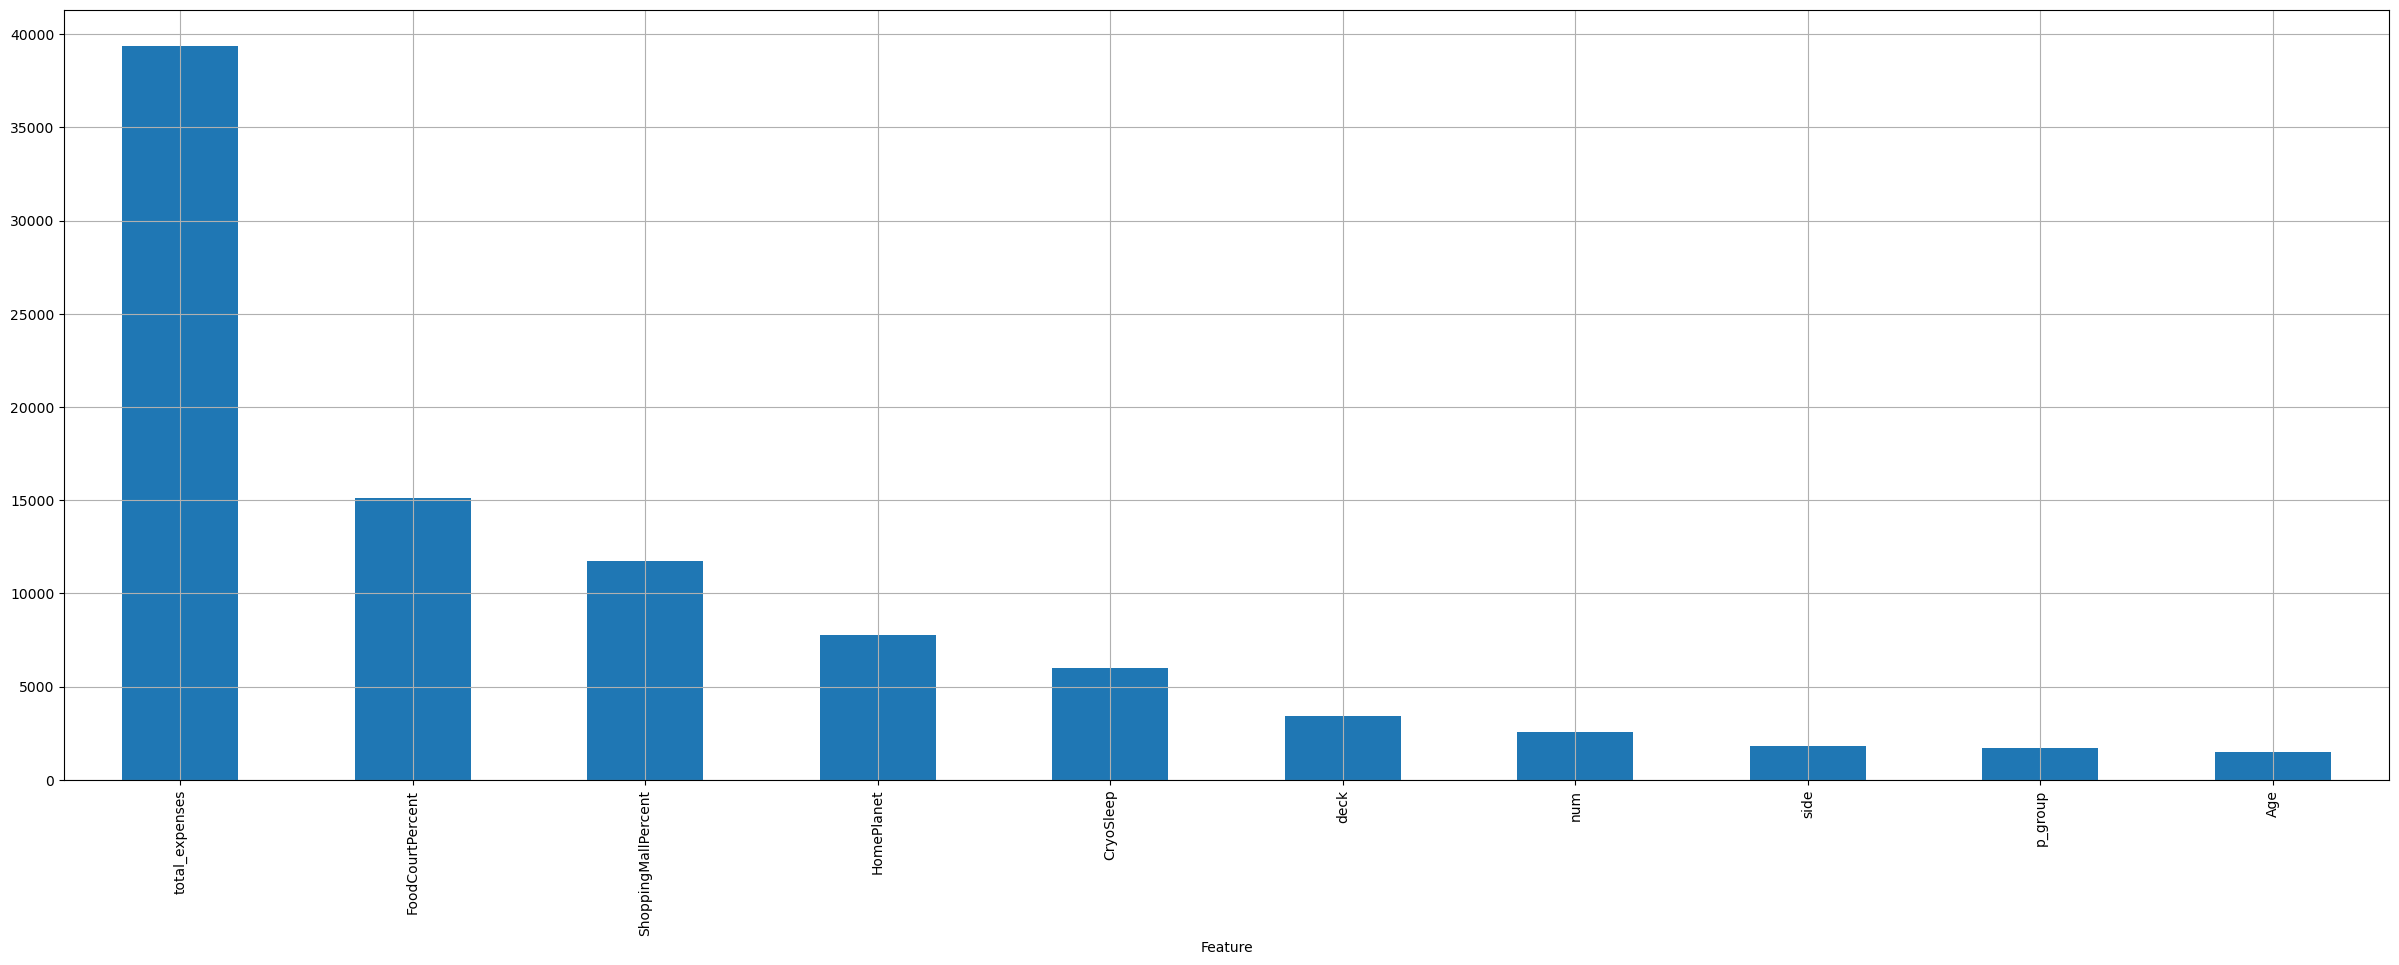

In [39]:
%%time

# Fast feature importances calculation
fast_fi = automl.get_feature_scores('fast')
fast_fi.set_index('Feature')['Importance'].head(10).plot.bar(figsize = (30, 10), grid = True)

In [41]:
fast_fi = pd.DataFrame(automl.get_feature_scores('fast'))
fast_fi.set_index('Feature')['Importance'].head(10)

Feature
total_expenses         39349.801312
FoodCourtPercent       15116.254826
ShoppingMallPercent    11734.188885
HomePlanet              7744.317672
CryoSleep               5991.615036
deck                    3417.556094
num                     2564.635675
side                    1791.240869
p_group                 1681.402342
Age                     1466.574076
Name: Importance, dtype: float64

In [66]:
lama1_fin_pred = (automl.predict(test_df).data[:,0] >= 0.5).astype(bool)
lama1_fin_pred = test_dataset[['PassengerId']].join(pd.DataFrame(lama1_fin_pred, columns = ['Transported']))

In [67]:
pd.DataFrame(lama1_fin_pred).to_csv('sample_submission_lama1.csv', index = False)

In [56]:
fin_pred1 = cat_model.predict(test_df.drop(columns = ['Transported'])) 

In [57]:
fin_pred1 = test_dataset[['PassengerId']].join(pd.DataFrame(fin_pred1, columns = ['Transported']))
fin_pred1.to_csv('sample_submission.csv', index = False)

# fin_pred1 0.803 Score in Kaggle


# Adding polynomes

In [43]:
train_df = all_data[all_data['Transported'].notna()]

le = LabelEncoder()
train_df['Transported']= le.fit_transform(train_df['Transported'])

test_df = all_data[all_data['Transported'].isna()]

train_df = train_df.drop(['p_name', 'surname', 'Name'], axis = 1)
test_df = test_df.drop(['p_name', 'surname', 'Name'], axis = 1)

print(train_df.shape, test_df.shape)

(8693, 27) (4277, 27)


C:\Users\admin\AppData\Local\Temp\ipykernel_6844\2334008941.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['Transported']= le.fit_transform(train_df['Transported'])


# Lama and poly

In [255]:
# all_data.info()

In [56]:
train_df = all_data[all_data['Transported'].notna()]

le = LabelEncoder()
train_df['Transported']= le.fit_transform(train_df['Transported'])

test_df = all_data[all_data['Transported'].isna()]




print(train_df.shape, test_df.shape)

(8693, 30) (4277, 30)


C:\Users\admin\AppData\Local\Temp\ipykernel_6844\723867850.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['Transported']= le.fit_transform(train_df['Transported'])


In [59]:
poly = PolynomialFeatures(degree=2, include_bias = False, interaction_only = True)

X_train, X_test, y_train, y_test = train_test_split(train_df
                                                    #.drop(['Transported'], axis = 1)
                                                    , train_df.Transported.astype(bool), shuffle= True)

num_cols = train_df.columns[X_train.dtypes != object].tolist()
cl = list()
for i in range(120):
    cl.append('col_%s' %i)

X_train_polyed = pd.DataFrame(poly.fit_transform(X_train[num_cols].drop(['Transported'], axis = 1)), columns = cl)
X_test_polyed = pd.DataFrame(poly.fit_transform(X_test[num_cols].drop(['Transported'], axis = 1)), columns = cl)
X_train = X_train.join(X_train_polyed)
X_test = X_test.join(X_test_polyed)


In [60]:
N_THREADS = 7
N_FOLDS = 5
# RANDOM_STATE = 42
TEST_SIZE = 0.2
# TIMEOUT = 300
TARGET_NAME = 'Transported'

In [61]:
task = Task('binary', metric='accuracy')
roles = {'target': TARGET_NAME,
#     'drop': ['SK_ID_CURR']
}
automl = TabularAutoML(
    task = task
#     ,timeout = TIMEOUT
    ,cpu_limit = N_THREADS
    ,reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS}
    ,general_params = {'nested_cv': False, 'use_algos': [['cb_tuned']]
#                       [['lgb','lgb_tuned','cb', 'cb_tuned']]
                      }
    ,tuning_params = {'max_tuning_iter': 500},
)

In [698]:
# X_train.info()

In [62]:
%%time
oof_pred = automl.fit_predict(X_train, roles = roles, verbose = 1)
tr_pred = automl.predict(X_train)
te_pred = automl.predict(X_test)
print(f'OOF score: {accuracy_score(X_train[TARGET_NAME], (oof_pred.data[:, 0] >= 0.5).astype(bool))}')
print(f'HOLDOUT score: {accuracy_score(X_test[TARGET_NAME].values, (te_pred.data[:, 0] >= 0.5).astype(bool))}')

[22:19:33] Stdout logging level is INFO.
[22:19:33] Task: binary

[22:19:33] Start automl preset with listed constraints:
[22:19:33] - time: 3600.00 seconds
[22:19:33] - CPU: 7 cores
[22:19:33] - memory: 16 GB

[22:19:33] Train data shape: (6519, 150)

[22:19:48] Layer 1 train process start. Time left 3585.66 secs


C:\Users\admin\AppData\Roaming\Python\Python39\site-packages\lightautoml\transformers\categorical.py:1029: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cnts = cnts.append(Series([cnts.shape[0] + 1], index=[np.nan]))
C:\Users\admin\AppData\Roaming\Python\Python39\site-packages\lightautoml\transformers\categorical.py:1029: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cnts = cnts.append(Series([cnts.shape[0] + 1], index=[np.nan]))
C:\Users\admin\AppData\Roaming\Python\Python39\site-packages\lightautoml\transformers\categorical.py:1029: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cnts = cnts.append(Series([cnts.shape[0] + 1], index=[np.nan]))
C:\Users\admin\AppData\Roaming\Python\Python39\site-packages\lightautoml\transf

[22:19:58] Selector_LightGBM fitting and predicting completed
[22:19:58] Start hyperparameters optimization for Lvl_0_Pipe_0_Mod_0_Tuned_CatBoost ... Time budget is 300.00 secs


C:\Users\admin\AppData\Roaming\Python\Python39\site-packages\lightautoml\transformers\categorical.py:1029: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cnts = cnts.append(Series([cnts.shape[0] + 1], index=[np.nan]))
C:\Users\admin\AppData\Roaming\Python\Python39\site-packages\lightautoml\transformers\categorical.py:1029: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cnts = cnts.append(Series([cnts.shape[0] + 1], index=[np.nan]))
C:\Users\admin\AppData\Roaming\Python\Python39\site-packages\lightautoml\transformers\categorical.py:1029: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cnts = cnts.append(Series([cnts.shape[0] + 1], index=[np.nan]))
C:\Users\admin\AppData\Roaming\Python\Python39\site-packages\lightautoml\transf

[22:24:59] Hyperparameters optimization for Lvl_0_Pipe_0_Mod_0_Tuned_CatBoost completed
[22:24:59] Start fitting Lvl_0_Pipe_0_Mod_0_Tuned_CatBoost ...
[22:25:15] Fitting Lvl_0_Pipe_0_Mod_0_Tuned_CatBoost finished. score = 0.8018100935726339
[22:25:15] Lvl_0_Pipe_0_Mod_0_Tuned_CatBoost fitting and predicting completed
[22:25:15] Time left 3257.82 secs

[22:25:15] Layer 1 training completed.

[22:25:15] Automl preset training completed in 342.20 seconds

[22:25:15] Model description:
Final prediction for new objects (level 0) = 
	 1.00000 * (5 averaged models Lvl_0_Pipe_0_Mod_0_Tuned_CatBoost) 

OOF score: 0.8018100935726339
HOLDOUT score: 0.8109475620975161
Wall time: 5min 43s


In [63]:
tr_pred = automl.predict(X_train)
te_pred = automl.predict(X_test)
print(f'OOF score: {accuracy_score(X_train[TARGET_NAME], (tr_pred.data[:, 0] > 0.5).astype(bool))}')
print(f'HOLDOUT score: {accuracy_score(X_test[TARGET_NAME].values, (te_pred.data[:, 0] > 0.5).astype(bool))}')

OOF score: 0.8370915784629545
HOLDOUT score: 0.8109475620975161


## Test improoved

In [64]:
test_df_polyed = pd.DataFrame(poly.fit_transform(test_df[num_cols].drop(['Transported'], axis = 1)), columns = cl)
test_df1 = test_df.join(test_df_polyed)#.drop(['Transported'], axis = 1)

In [65]:
fin_pred2 = automl.predict(test_df1)#.drop(columns = ['Cabin', 'Name', 'PassengerId']))
fin_pred2 = test_dataset[['PassengerId']].join(pd.DataFrame((fin_pred2.data[:, 0] > 0.5).astype(bool)
                                                            , columns = ['Transported']))
fin_pred2.to_csv('sample_submission_lama_poly.csv', index = False)
# same result

# Stacking

In [66]:
train_df = all_data[all_data['Transported'].notna()]

le = LabelEncoder()
train_df['Transported']= le.fit_transform(train_df['Transported'])

test_df = all_data[all_data['Transported'].isna()]

train_df = train_df.drop(['p_name', 'surname', 'Name'], axis = 1)
test_df = test_df.drop(['p_name', 'surname', 'Name'], axis = 1)

print(train_df.shape, test_df.shape)

(8693, 27) (4277, 27)


C:\Users\admin\AppData\Local\Temp\ipykernel_6844\2334008941.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['Transported']= le.fit_transform(train_df['Transported'])


In [78]:
to_drop = ['Cabin','Name', 'p_name', 'surname', 'PassengerId', 'p_group']
categ_features = ['Destination', 'HomePlanet', 'deck', 'side', 'CryoSleep', 'VIP', 'no_name']
train_df[categ_features] = train_df[categ_features].astype(str)

In [68]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

In [85]:
estimators = [
    ('cat', CatBoostClassifier(eval_metric='Accuracy', iterations = 500,
                               cat_features=categ_features
#                               ,max_depth = 5
                               ,verbose = 0
                              ))
 ]
clf = StackingClassifier(estimators=estimators, 
                         final_estimator=CatBoostClassifier(verbose = 0, eval_metric='Accuracy', iterations = 1500,
#                                cat_features=categ_features
                                                           ))

In [86]:
X_train, X_test, y_train, y_test = train_test_split(train_df.drop(['Transported', 'Cabin', 'PassengerId'], axis = 1)
                                                    , train_df.Transported.astype(bool), shuffle= True)

In [88]:
# X_train.tail()

In [89]:
%%time
clf.fit(X_train, y_train)#.score(X_test, y_test) #0.88763 0stage

Wall time: 2min 12s


StackingClassifier(estimators=[('cat',
                                <catboost.core.CatBoostClassifier object at 0x000002DE9987B3D0>)],
                   final_estimator=<catboost.core.CatBoostClassifier object at 0x000002DE9987BAF0>)

In [90]:
train_preds = clf.predict(X_train)#.drop(columns = ['Transported', 'Cabin', 'PassengerId']))
test_preds = clf.predict(X_test)#.drop(columns = ['Transported', 'Cabin', 'PassengerId']))
print('Train: {:.3f}'.format(accuracy_score(train_preds.astype(bool), y_train.astype(bool))))
print('Test: {:.3f}'.format(accuracy_score(test_preds.astype(bool), y_test.astype(bool))))#.astype(bool)

Train: 0.860
Test: 0.824


In [92]:
test_df1 = test_df.copy()
# test_df1[categ_features] = test_df1[categ_features].astype(str)

In [93]:
fin_pred_stack = clf.predict(test_df1.drop(columns = ['Cabin', 'PassengerId', 'Transported']))
fin_pred_stack = test_df1[['PassengerId']].join(pd.DataFrame(fin_pred_stack
                                                            , columns = ['Transported'], index = test_df1.index))
fin_pred_stack.to_csv('sample_submission_stacking.csv', index = False)
# тот же результат

In [177]:
# fin_pred_stack